In [1]:
# Color model test

In [1]:
import numpy as np
import pathlib
import pyexr
import rawpy
import tensorflow as tf

# Prevent TensorFlow from allocating all GPU memory.
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-06-03 22:39:54.616493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749015594.627866   36556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749015594.631522   36556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749015594.641695   36556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749015594.641703   36556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749015594.641705   36556 computation_placer.cc:177] computation placer alr

In [2]:
from cnn_demosaic import color
from cnn_demosaic import color_model
from cnn_demosaic import config
from cnn_demosaic import exposure
from matplotlib import pyplot as plt

In [3]:
def display_image(image):
    plt.imshow(image, vmin=0, vmax=1, cmap="gray")
    plt.show()


def to_color_arr(img_arr):
    """Flatten the 2D image to an array."""
    rgb_arr = img_arr[:, :, :3]
    return rgb_arr.reshape((rgb_arr.size // 3, 3))

In [4]:
col_weights_path = config.get_weights_resource_path(None, "color_transform.weights.h5")
col_model = color_model.create_color_transform_model(col_weights_path)
col = color.ColorTransform(col_model)

wb_weights_path = config.get_weights_resource_path(None, "white_balance.weights.h5")
wb_model = color_model.create_white_balance_model(wb_weights_path)
wb = color.WhiteBalance(wb_model)


I0000 00:00:1749015596.792941   36556 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:07:00.0, compute capability: 8.6
/home/jake/git/cnn_demosaic/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
DATASET_PREFIX = "/media/jake/Media/datasets/fuji_raw/xe2"
TEST_EXR_PATH = f"{DATASET_PREFIX}/train/DSCF5760.exr"
TEST_RAW_PATH = f"{DATASET_PREFIX}/train/DSCF5760.RAF"


In [9]:

def get_wb_matrix(raw_path):
    with rawpy.imread(raw_path) as raw_img:
        camera_whitebalance = raw_img.camera_whitebalance
    cam_whitebalance = np.asarray(camera_whitebalance)[:3] / 512.0
    return cam_whitebalance


def process_both(exr_path, raw_path):
    wb_matrix = get_wb_matrix(raw_path)
    exr_img_arr = pyexr.read(f"{exr_path}")[:, :, :3]
    orig_shape = exr_img_arr.shape
    output_arr = wb.process(to_color_arr(exr_img_arr), wb_matrix)
    print(output_arr.shape)
    output_arr = col.process(output_arr)
    print(output_arr.shape)
    display_image(np.asarray(output_arr).reshape(orig_shape))



**** shape: [[ 0.8083275  -0.7051665  -0.9073873 ]
 [ 0.7961615  -0.69560254 -0.8952741 ]
 [ 0.796581   -0.69192404 -0.8952741 ]
 ...
 [ 0.5945827  -0.302743   -0.61887205]
 [ 0.5945827  -0.30384654 -0.6208909 ]
 [ 0.5950022  -0.30458224 -0.6229098 ]]
(15980544, 3)
**** len: 15980544
**** size orig: 47941632 out: 3
**** shape orig: (15980544, 3) out: (3,)
(15980544, 3)


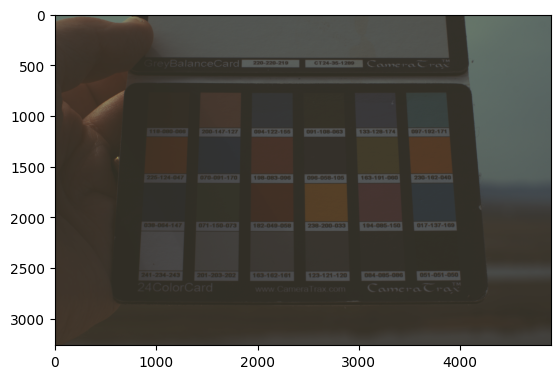

In [10]:
process_both(TEST_EXR_PATH, TEST_RAW_PATH)